## Prepare Dataset

### Flow count for VPN and non-VPN

label
NoVPN    43597
VPN       8350
Name: count, dtype: int64


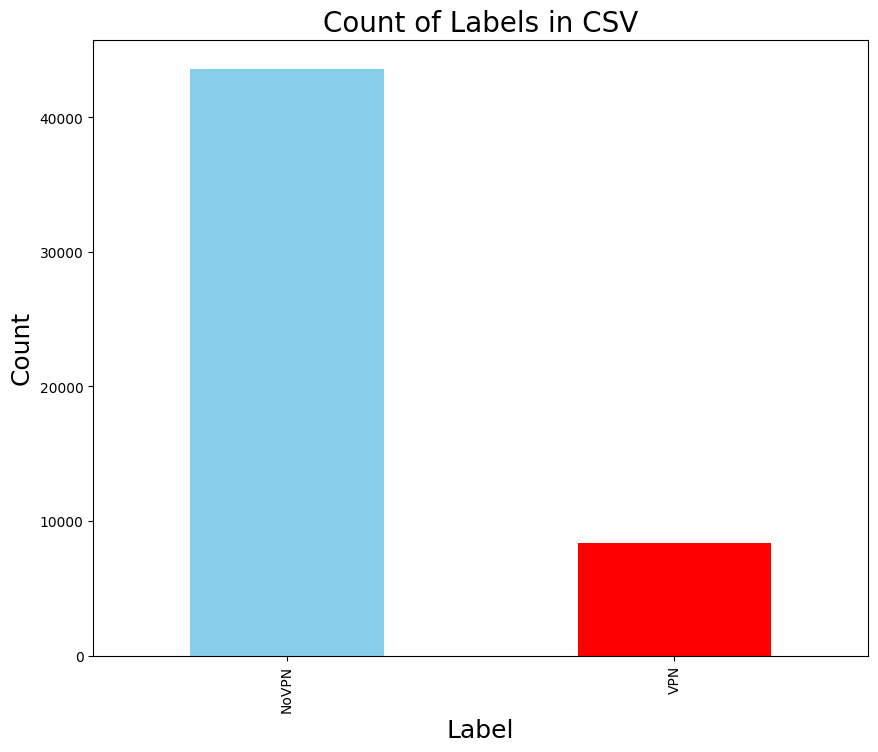

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./VNAT/WF/flows_extra_labelled_5.csv',low_memory=False)

label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 8))  
label_counts.plot(kind='bar', color=['skyblue', 'red'])  

plt.title('Count of Labels in CSV', fontsize=20)
plt.xlabel('Label', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()


### Create a dataset for Wavelet Features and filter the flows with less than 20 packets

In [2]:
import pandas as pd

import numpy as np

filtered_df = pd.read_csv('./VNAT/WF/flows_extra_labelled_5.csv',low_memory=False)

filtered_df = filtered_df[filtered_df['bidirectional_packets'] > 19]
 
columns_to_select = [
                     #select Wavelet features
                     #forward
                    'udps.f_p_k_0','udps.f_p_k_1','udps.f_p_k_2','udps.f_p_k_3','udps.f_p_k_4','udps.f_p_k_5',
                     'udps.f_u_k_0','udps.f_u_k_1','udps.f_u_k_2','udps.f_u_k_3','udps.f_u_k_4','udps.f_u_k_5',
                     'udps.f_sigma_k_0','udps.f_sigma_k_1','udps.f_sigma_k_2','udps.f_sigma_k_3','udps.f_sigma_k_4','udps.f_sigma_k_5',
                     'udps.f_S_k_0','udps.f_S_k_1','udps.f_S_k_2','udps.f_S_k_3','udps.f_S_k_4','udps.f_S_k_5',
                      #backward
                     'udps.b_p_k_0','udps.b_p_k_1','udps.b_p_k_2','udps.b_p_k_3','udps.b_p_k_4','udps.b_p_k_5', 
                     'udps.b_u_k_0','udps.b_u_k_1','udps.b_u_k_2','udps.b_u_k_3','udps.b_u_k_4','udps.b_u_k_5',
                     'udps.b_sigma_k_0','udps.b_sigma_k_1','udps.b_sigma_k_2','udps.b_sigma_k_3','udps.b_sigma_k_4','udps.b_sigma_k_5',
                     'udps.b_S_k_0','udps.b_S_k_1','udps.b_S_k_2','udps.b_S_k_3','udps.b_S_k_4','udps.b_S_k_5'
                   , 'label','category']

df_WNF = filtered_df[columns_to_select]                  
 
df_WNF.to_csv('./VNAT/WF/flows_extra_labelled_WF5_filtered.csv', index=False)
 

### Flow count for VPN and non-VPN after filtering

label
NoVPN    8148
VPN      6469
Name: count, dtype: int64


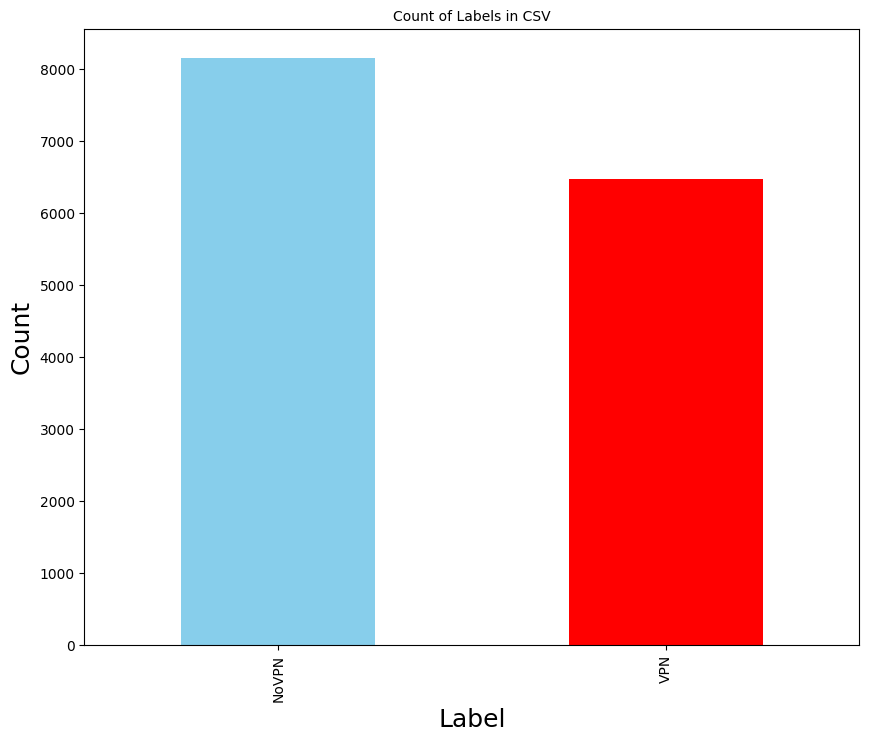

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./VNAT/WF/flows_extra_labelled_WF5_filtered.csv',low_memory=False)

label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 8))  
label_counts.plot(kind='bar', color=['skyblue', 'red'])  
plt.title('Count of Labels in CSV', fontsize=10)
plt.xlabel('Label', fontsize=18)
plt.ylabel('Count', fontsize=18)

plt.show()


### Rndom Forest

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_WF5_filtered.csv'  
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['non-VPN', 'VPN'], 
yticklabels=['non-VPN', 'VPN'], annot_kws={"size": 16})  
plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_RF5_filtered.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()

accuracy_report_path = os.path.join(output_dir, "RF5_filtered.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test.loc[misclassified_mask].copy()

misclassified_samples['true_label'] = y_test.loc[misclassified_mask]
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask]

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "RF5_filtered.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Train Accuracy: 1.0
Test Accuracy: 0.9764021887824897

Confusion Matrix:
[[0.97751405 0.02248595]
 [0.02494331 0.97505669]]

Classification Report:
              precision    recall  f1-score   support

       NoVPN       0.98      0.98      0.98      1601
         VPN       0.97      0.98      0.97      1323

    accuracy                           0.98      2924
   macro avg       0.98      0.98      0.98      2924
weighted avg       0.98      0.98      0.98      2924


Detailed Misclassification Summary (per Category):
            category true_label predicted_label  count
0               Chat      NoVPN             VPN     22
1               Chat        VPN           NoVPN     21
2  Command & Control      NoVPN             VPN      3
3  Command & Control        VPN           NoVPN      2
4      File Transfer      NoVPN             VPN      3
5      File Transfer        VPN           NoVPN      3
6          Streaming      NoVPN             VPN      8
7          Streaming        VPN  

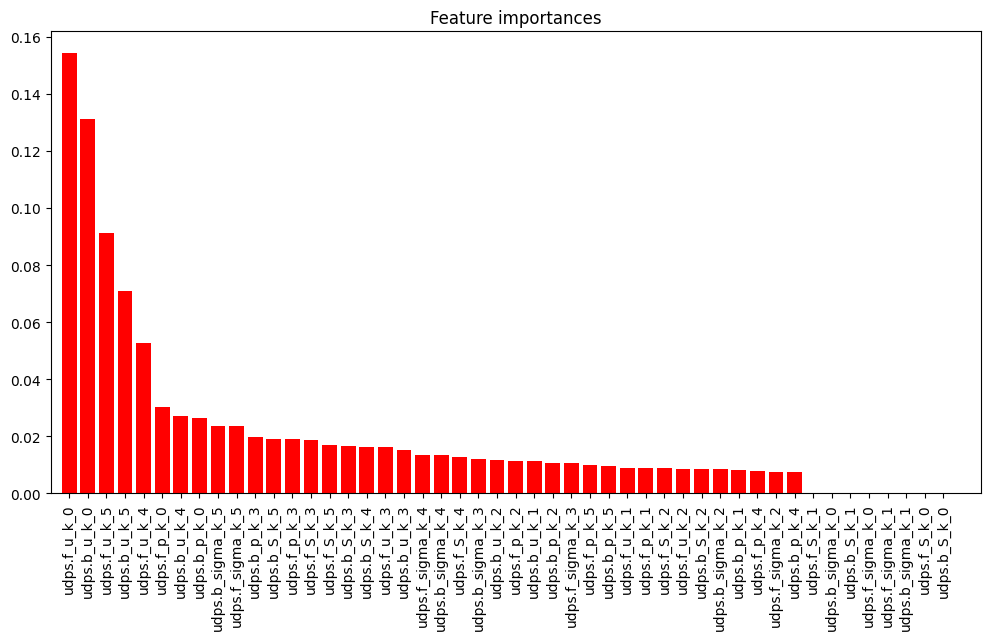

In [18]:
# feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]+1])
plt.show()

### SVM

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_WF5_filtered.csv'  
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

clf = LinearSVC(random_state=42, max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], 
yticklabels=['NoVPN', 'VPN'], annot_kws={"size": 16})  

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_SVM5.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()

accuracy_report_path = os.path.join(output_dir, "SVM5_filtered.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test.loc[misclassified_mask].copy()

misclassified_samples['true_label'] = y_test.loc[misclassified_mask]
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask]

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "SVM5_filtered.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Train Accuracy: 0.8357991961002309
Test Accuracy: 0.8327633378932968

Confusion Matrix:
[[0.8376015  0.1623985 ]
 [0.17309146 0.82690854]]

Classification Report:
              precision    recall  f1-score   support

       NoVPN       0.85      0.84      0.85      1601
         VPN       0.81      0.83      0.82      1323

    accuracy                           0.83      2924
   macro avg       0.83      0.83      0.83      2924
weighted avg       0.83      0.83      0.83      2924


Detailed Misclassification Summary (per Category):
            category true_label predicted_label  count
0               Chat      NoVPN             VPN    190
1               Chat        VPN           NoVPN     87
2  Command & Control      NoVPN             VPN     20
3  Command & Control        VPN           NoVPN     67
4      File Transfer      NoVPN             VPN      4
5      File Transfer        VPN           NoVPN     59
6          Streaming      NoVPN             VPN     34
7          Streami

### Neural Network

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras

output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_WF5_filtered.csv' 
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], 
yticklabels=['NoVPN', 'VPN'], annot_kws={"size": 16})  # Enlarged numbers inside the matrix

plt.xlabel("Predicted Label", fontsize=20)
plt.ylabel("True Label", fontsize=20)
plt.title("", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

conf_matrix_path = os.path.join(output_dir, "confusion_matrix_NN5_filtered.png")
plt.savefig(conf_matrix_path, dpi=300, bbox_inches='tight')
plt.close()

accuracy_report_path = os.path.join(output_dir, "NN5_filtered.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test[misclassified_mask]

misclassified_samples = pd.DataFrame(misclassified_samples, columns=X.columns)
misclassified_samples['true_label'] = y_test.loc[misclassified_mask].values
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask].values

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "NN5_filtered.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Epoch 1/20


C:\Users\yasah\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6430 - loss: 0.6180 - val_accuracy: 0.7531 - val_loss: 0.5513
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7613 - loss: 0.5222 - val_accuracy: 0.8642 - val_loss: 0.3857
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8795 - loss: 0.3665 - val_accuracy: 0.9066 - val_loss: 0.2964
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9059 - loss: 0.2781 - val_accuracy: 0.9083 - val_loss: 0.2574
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9168 - loss: 0.2459 - val_accuracy: 0.9145 - val_loss: 0.2429
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9220 - loss: 0.2196 - val_accuracy: 0.9138 - val_loss: 0.2211
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9270 - loss: 0.1914 - val_accuracy: 0.9251 - val_loss: 0.2088
Epoch 8/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9305 - loss: 0.1883 - val_accuracy: 0.9189 - val_